In [1]:
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np 
import seaborn as sns
import os, sys
from hsbmpy import get_file, define_labels, get_cluster_given_l
from sklearn.metrics import homogeneity_completeness_v_measure
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
level = 2
#setup = 'oversigma_10tissue'
#label = 'disease_type'
label='primary_site'
#label = 'uniq'
L = 4
#labels = ['primary_site', 'disease_type']
#labels = ['primary_site', 'secondary_site']
directory=r"/home/fvalle/phd/results/tcga/oversampling_10tissue"
#directory=r"/home/fvalle/phd/results/altmann"
os.chdir(directory)

In [3]:
df = pd.read_csv("mainTable.csv", index_col=[0], header=[0])
totalobjcets = len(df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3739 entries, ENSG00000172137 to ENSG00000181518
Columns: 793 entries, efb7b03d-e283-47be-9233-edf945abb012.htseq.counts.gz to 25b57a17-29ab-41f6-8809-45cf5b58a329.htseq.counts.gz
dtypes: int64(793)
memory usage: 22.6+ MB


In [4]:
df_files = pd.read_csv("files.dat", index_col=[0])
df_files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, 1ede5c59-96ae-486b-ae1f-5f7c7909cf6a.htseq.counts.gz to 866db25b-6fe3-4423-9616-f603b200e188.htseq.counts.gz
Data columns (total 2 columns):
primary_site    793 non-null object
disease_type    793 non-null object
dtypes: object(2)
memory usage: 18.6+ KB


In [5]:
true_out = []
for sample in df.columns.values:
    try:
        true_out.append(get_file(sample, df_files)['primary_site'])
    except:
        print(sys.exc_info()[0])
        true_out.append('')

In [6]:
scores = {}

In [7]:
with open("clustersizes.txt",'r') as f:
    xl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

In [8]:
df.T.values.shape

(793, 3739)

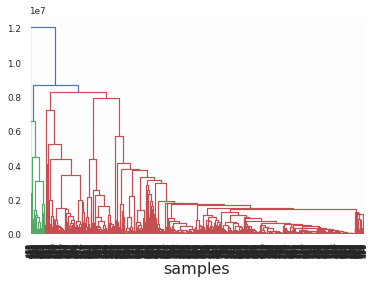

In [9]:
fig=plt.figure()
dend = shc.dendrogram(shc.linkage(df.T.values, method='ward'), leaf_rotation=90., leaf_font_size=8.,)
plt.xlabel("samples", fontsize=16)
plt.show()
fig.savefig("hierarchical_dendogram.pdf")

In [ ]:
#hierarchical
scores['hierarchical']={
    'h':[],
    'c':[],
    'V':[]
}
print("hierarchical")
os.system('mkdir -p hierarchical')
hierarchical_model = AgglomerativeClustering(n_clusters=1, affinity='euclidean', linkage='complete')  
for l,x in enumerate(xl):
    print("testing with %d clusters"%x)
    hierarchical_model.n_clusters=x
    out = hierarchical_model.fit_predict(df.T.values)
        
    #save clusters
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(totalobjcets))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df.columns[np.argwhere(out==c)].values.T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(totalobjcets-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierarchical/hierarchical_level_%d_clusters.csv"%(l), index=False, header=True)
    
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['hierarchical']['h'].append(score[0])
    scores['hierarchical']['c'].append(score[1])
    scores['hierarchical']['V'].append(score[2])
    
pd.DataFrame(data=scores['hierarchical']).to_csv("hierarchical.scores", header=True, index=False)

## LDA

In [12]:
with open("topicsizes.txt",'r') as f:
    tl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

In [61]:
xl = [10,50,100,500]
tl = [10, 50, 100,500]
Sigmas = []

In [62]:
scores['lda']={
    'h':[],
    'c':[],
    'V':[]
}
print("lda")
os.system('mkdir -p lda')
lda = LatentDirichletAllocation(n_components=1, 
                                    random_state=42, 
                                    n_jobs=1, 
                                    learning_method='online', 
                                    max_doc_update_iter=5,
                                    max_iter=5,
                                    topic_word_prior=1,
                                    doc_topic_prior=1,
                                    verbose=2)
for l,x in enumerate(xl):
    #lda
    ntopic = tl[l]
    #ntopic = x
    print("testing with %d clusters and %d topics"%(x,ntopic))
    lda.n_components=ntopic
    print(lda)
    topics = lda.fit_transform(df.T.values)
    
    #save word distr
    print("saving word-distr")
    df_word_distr = pd.DataFrame(data=lda.components_.T, index=df.index, columns=["Topic %d"%(t+1) for t in np.arange(ntopic)])
    df_word_distr.to_csv("lda/lda_level_%d_word-dist.csv"%l, index=True, header=True)
    
    #save topic distr
    print("saving topic-distr")
    df_topic_distr = pd.DataFrame(data=topics, columns=["Topic %d"%(t+1) for t in np.arange(ntopic)])
    df_topic_distr.insert(0,'i_doc',np.arange(len(df.columns)))
    df_topic_distr.insert(1,'doc',df.columns)
    df_topic_distr.to_csv("lda/lda_level_%d_topic-dist.csv"%l, index=False, header=True)
    
    #save clusters
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(totalobjcets))
    #cluster = AgglomerativeClustering(n_clusters=x, affinity='euclidean', linkage='ward')  
    #out = cluster.fit_predict(topics)
    out = np.argmax(topics, axis=1)
    
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df.columns[np.argwhere(out==c)].values.T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(totalobjcets-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("lda/lda_level_%d_clusters.csv"%(l), index=False, header=True)
    
    #metrics
    print("saving metrics")
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['lda']['h'].append(score[0])
    scores['lda']['c'].append(score[1])
    scores['lda']['V'].append(score[2])
    
    #save dl
    Sigmas.append(-lda.score(df.values.T))
    
pd.DataFrame(data=scores['lda']).to_csv("%s/lda.scores"%directory, header=True, index=False)

lda
testing with 10 clusters and 10 topics
LatentDirichletAllocation(batch_size=128, doc_topic_prior=1, evaluate_every=-1,
                          learning_decay=0.7, learning_method='online',
                          learning_offset=10.0, max_doc_update_iter=5,
                          max_iter=5, mean_change_tol=0.001, n_components=10,
                          n_jobs=1, perp_tol=0.1, random_state=42,
                          topic_word_prior=1, total_samples=1000000.0,
                          verbose=2)
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
saving word-distr
saving topic-distr
saving clusters
saving metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

testing with 50 clusters and 50 topics
LatentDirichletAllocation(batch_size=128, doc_topic_prior=1, evaluate_every=-1,
                          learning_decay=0.7, learning_method='online',
                          learning_offset=10.0, max_doc_update_iter=5,
                          max_iter=5, mean_change_tol=0.001, n_components=50,
                          n_jobs=1, perp_tol=0.1, random_state=42,
                          topic_word_prior=1, total_samples=1000000.0,
                          verbose=2)
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

saving word-distr
saving topic-distr
saving clusters
saving metrics
testing with 100 clusters and 100 topics
LatentDirichletAllocation(batch_size=128, doc_topic_prior=1, evaluate_every=-1,
                          learning_decay=0.7, learning_method='online',
                          learning_offset=10.0, max_doc_update_iter=5,
                          max_iter=5, mean_change_tol=0.001, n_components=100,
                          n_jobs=1, perp_tol=0.1, random_state=42,
                          topic_word_prior=1, total_samples=1000000.0,
                          verbose=2)
iteration: 1 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics
testing with 500 clusters and 500 topics
LatentDirichletAllocation(batch_size=128, doc_topic_prior=1, evaluate_every=-1,
                          learning_decay=0.7, learning_method='online',
                          learning_offset=10.0, max_doc_update_iter=5,
                          max_iter=5, mean_change_tol=0.001, n_components=500,
                          n_jobs=1, perp_tol=0.1, random_state=42,
                          topic_word_prior=1, total_samples=1000000.0,
                          verbose=2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [63]:
Sigmas

[277209.87360436836, 286471.42312461976, 288577.7857844125, 342245.58609012153]

In [17]:
homogeneity_completeness_v_measure(true_out, out)

(0.4375063841949788, 0.7449935483935977, 0.5512718007395827)

## hierachical on Altmann's output

In [ ]:
hiermodel = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')

In [ ]:
with open('clustersizes.txt') as f:
    xl=np.array(f.read().split('\n')[:-1]).astype(int)

In [ ]:
os.system("mkdir -p hierhsbm")

In [ ]:
true_out = []
for sample in pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',0), index_col=1).drop('i_doc', axis=1).index.values:
    try:
        true_out.append(get_file(sample, df_files)['primary_site'])
    except:
        print(sys.exc_info()[0])
        true_out.append('')

In [ ]:
scores['hierhsbm']={
    'h':[],
    'c':[],
    'V':[]
}
for l,n_clusters in enumerate(xl):
    print("Fitting level %d with %d clusters"%(l, n_clusters))
    df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%('topsbm','topsbm',l), index_col=1).drop('i_doc', axis=1)
    df_clusters = pd.DataFrame(columns=["Cluster %d"%c for c in np.arange(n_clusters)+1])
    hiermodel.n_clusters=n_clusters
    out = hiermodel.fit_predict(df_topics.values)  
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df_topics.index[np.argwhere(out==c)].values.T[0]
        df_clusters["Cluster %d"%(c+1)]=np.concatenate((c_objects,[np.nan for _ in np.arange(len(df_topics.index)-len(c_objects))]))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierhsbm/hierhsbm_level_%d_clusters.csv"%(l), index=False, header=True)
    #metrics
    print("saving metrics")
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['hierhsbm']['h'].append(score[0])
    scores['hierhsbm']['c'].append(score[1])
    scores['hierhsbm']['V'].append(score[2])
    
pd.DataFrame(data=scores['hierhsbm']).to_csv("%s/hierhsbm.scores"%directory, header=True, index=False)